# Getting Started
Welcome to petitRADTRANS!
This series of tutorials will outline the basic features of pRT, from how to generate emission and transmission spectra to running atmospheric retrievals.
If you'd like to run the tutorial notebooks yourself, they're [available on gitlab](https://gitlab.com/mauricemolli/petitRADTRANS/-/tree/master/docs/content/notebooks?ref_type=heads).

## Preparing a radiative transfer object

After installation has finished, let's try to calculate a first spectrum! First we load required external packages though:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Then we'll load pRT by importing:

In [2]:
from petitRADTRANS.radtrans import Radtrans

We also need the physical constants module:

In [3]:
from petitRADTRANS import physical_constants as cst

### The `Radtrans` object

Let's start out by creating a radiative transfer object using the `Radtrans` object.

This will load the requested opacities and create an object ready to calculate spectra once the atmospheric parameters (temperature, abundances, mean molar mass etc.) are set. We will explain the meaning of the function's inputs below.

In [ ]:
radtrans = Radtrans(
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    wavelength_boundaries=[0.3, 15]
)

First we define the pressure array of the atmosphere. Note that the pressures **must** always be sorted in increasing order, and be equidistant in log-space. The pressure is given to pRT in units of **bar**, although the inernal units in petitRADTRANS are in cgs. Typically we recommend using around 100 layers in your computations. However, be careful, internally pRT converts the pressure to cgs units!

Next we define the line absorbers to be used for the calculation (``line_species = ...``). If you have a fresh pRT installation, your opacity folder will be empty. pRT will automatically download the species which are missing. Here we asked for the following molecular or atomic line absorbers to be inlcuded: ``H2O``, ``CO-NatAbunds`` (all isotopologues at naturally occuring isotope abundances on Earth),  ``CH4``, ``CO2``, ``Na``, and ``K``. More information on the data loading process in the [next section](#loading_opacities).

Additionally, the Rayleigh scattering cross-sections for ``H2`` and ``He`` were loaded, as well as the collision induced absorption (CIA) cross-sections for the ``H2-H2`` and ``H2-He`` pairs, called ``gas_continuum_contributors`` above.

The wavelength range that was loaded for the opacities here extends from 0.3 to 15 microns.

And we are done! This step only needs to be carried out once, after this we are free to play with this radiative transfer (``Radtrans``) object, for example change the temperature, abundances, etc. Only if additional opacity species need to be loaded is it necessary to create a new Radtrans instance.

<div class="alert alert-warning">

**Units in petitRADTRANS:** all units inside *petitRADTRANS* are in cgs. However, when interfacing with the code, you are expected to provide pressures in bars (more intuitive). Pressures will be converted to cgs units within the code.
</div>

### Loading opacities <a id='loading_opacities'></a>
Opacities can have different sources. You can either select one of them by adding tags such as ``__HITEMP`` or ``__Allard`` to the absorber names (e.g., ``H2O__HITEMP`` or ``H2O__Exomol``) or by just writing ``H2O`` and setting a default line list, that will be saved for future uses (see information in the [next section](#configuration) for more details). pRT will do this by automatically asking you the first time you request a species (e.g., ``H2O``) for which multiple options are available.

If you do not want to run at pRT's standard resolution for correlated-k opacities ($\lambda/\Delta\lambda = 1,000$) you can reqest another spectral resolution with ``.R300``, so ``H2O.R300``, for example. This will bin down the opacities accordingly, and add them to the input data folder in this new resolution. This is described more in ["Rebinning opacities"](rebinning_opacities.html#Binning-opacities-in-c-k-mode).

More information on the file naming convention and opacity request are available in the [opacities section](../available_opacities.rst).

### Configuring the input_data folder
One of the most important things to setup pRT is to give the path to the input_data folder, where critical data such as opacities are stored.

This path is managed by the pRT config file. You may have seen that it has been automatically generated after importing a `Radtrans` object for the first time. 

By default, the input_data folder is placed into your home directory, under `<home>/petitRADTRANS/input_data`. To set the input_data path manually, the simplest way is to execute the following, giving the path corresponding to your setup:

In [ ]:
from petitRADTRANS.config import petitradtrans_config_parser

petitradtrans_config_parser.set_input_data_path(r'~/petitRADTRANS/input_data')  # replace this path with the actual path to your input_data directory

<div class="alert alert-block alert-info">
<a id='configuration'></a>
    
**petitRADTRANS config file:** `petitradtrans_config_parser` is an object derived from [the `ConfigParser` Python standard object](https://docs.python.org/3/library/configparser.html). It is a way to easily manage customizable software configuration. 

When instantiated for the first time, `petitradtrans_config_parser` will create a `petitradtrans_config_file.ini` file in a `.petitradtrans` directory in your home directory. You can access this file and modify it manually if you want to. The default opacities to load (in case there are multiple options, e.g., ``H2O__HITEMP`` or ``H2O__Exomol`` for water), as well as the link to download opacities, are stored in this file too.
</div>

### Locating the input_data folder

The input_data folder can be located as follows:

In [ ]:
from petitRADTRANS.config import petitradtrans_config_parser

petitradtrans_config_parser.get_input_data_path()

## Calculating a transmission spectrum

Let's calculate a spectrum for a hot Jupiter, first in transmission. Let's assume an isothermal temperature profile, for now. We start by specifing the temperature array, and abundance dictionery, containing the mass fractions of the atmospheric material, at every layer, and the mean molar masses, at every layer, in units of g:

In [6]:
temperatures = 1200 * np.ones_like(radtrans.pressures) # note that radtrans.pressures is in cgs units now, multiply by 1e-6 to get bars

mass_fractions = {
    'H2': 0.74 * np.ones(temperatures.size),
    'He': 0.24 * np.ones(temperatures.size),
    'H2O': 1e-3 * np.ones(temperatures.size),
    'CO-NatAbund': 1e-2 * np.ones(temperatures.size),
    'CO2': 1e-4 * np.ones(temperatures.size),
    'CH4': 1e-5 * np.ones(temperatures.size),
    'Na': 1e-4 * np.ones(temperatures.size),
    'K': 1e-6 * np.ones(temperatures.size)
}

#  2.33 is a typical value for H2-He dominated atmospheres
mean_molar_masses = 2.33 * np.ones(temperatures.size)

**Note the P-T profile of a real planet will likely be different (e.g., not isothermal). Also the abundances are made up for this simple example here** (see ["Interpolating chemical equilibrium abundances"](interpolating_chemical_equilibrium_abundances.ipynb) for how to improve this.)

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). One can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the molar mass of a molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molar mass, and $n_i$ is the VMR of species $i$. This is implemented in `petitRADTRANS.chemistry.utils.mass_fractions2volume_mixing_ratios()` and `petitRADTRANS.chemistry.utils.volume_mixing_ratios2mass_fractions()`.

</div>

Next, let's assume a planetary radius and gravity at a given reference pressure (in **bar**!) in the atmosphere, and we are all set!

In [7]:
planet_radius = 1.0 * cst.r_jup_mean
reference_gravity = 10 ** 3.5
reference_pressure = 0.01

Now we simply generate a transmission spectrum. The ``calculate_transit_radii`` returns wavelengths in cm and transit radius in cm, as well as a dictionary of additional optional outputs, which is empty in our example, since we did not request anything in addition.

In [8]:
wavelengths, transit_radii, _ = radtrans.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure
)

Let's plot the transit radius!

Text(0, 0.5, 'Transit radius [$\\rm R_{Jup}$]')

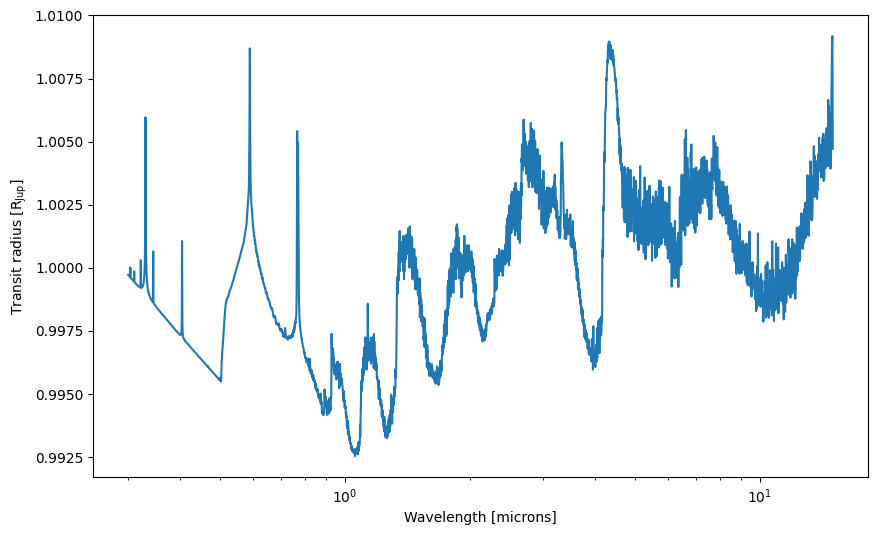

In [9]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths * 1e4, transit_radii / cst.r_jup_mean)
ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit radius [$\rm R_{Jup}$]')

## Calculating an emission spectrum

<div class="alert alert-warning">

**Scattering and petitRADTRANS:** scattering is included for emission spectra in petitRADTRANS only if requested specifically when generating the Radtrans object, as it increases the runtime (see ["Scattering for Emission Spectra"](scattering_for_emission_spectra.ipynb) for an example on how to do this). We neglect the scattering here.

</div>

Let's calculate an emission spectrum. Using the isothermal temperature structure from above will simply result in a black body spectrum.
pRT returns all spectra in cgs units at the planetary "surface" (i.e., the top of the atmosphere).

Text(0, 0.5, 'Planet flux, $F_{\\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

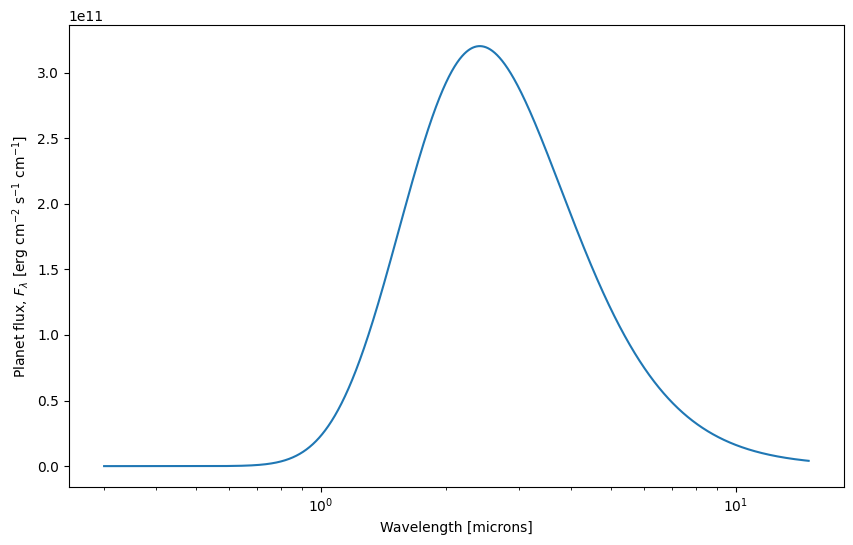

In [10]:
wavelengths, flux, _ = radtrans.calculate_flux(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses = mean_molar_masses,
    reference_gravity = reference_gravity
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wavelengths * 1e4, flux)

plt.xscale('log')
ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

<div class="alert alert-warning">

**Standard flux units:** before pRT3 flux was accessed as `atmosphere.flux` after running `atmosphere.calc_flux()`, which contained flux as $F_\nu$, so in units of erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$. pRT's `calculate_flux()` method now returns wavelength and flux as $F_\lambda$ in its standard setting, so flux in erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$. To return frequencies and $F_\nu$, instead of wavelengths and $F_\lambda$, please set the keyword `frequencies_to_wavelengths=False` when calling `calculate_flux()`.

</div>

Let's try a different temperature structure instead, namely the often-used analytical profile from [Guillot (2010)](http://adsabs.harvard.edu/abs/2010A%26A...520A..27G), his Equation 29:

\begin{equation}
T^4 = \frac{3T_{\rm int}^4}{4}\left(\frac{2}{3}+\tau\right) + \frac{3T_{\rm equ}^4}{4}\left[\frac{2}{3}+\frac{1}{\gamma\sqrt{3}}+\left(\frac{\gamma}{\sqrt{3}}-\frac{1}{\gamma\sqrt{3}}\right)e^{-\gamma\tau\sqrt{3}}\right]
\end{equation}

with $\tau = P\kappa_{\rm IR}/g$. Here, $\tau$ is the optical depth, $P$ the pressure, $\kappa_{\rm IR}$ is the atmospheric opacity in the IR wavelengths (i.e., the cross-section per unit mass), $\gamma$ is the ratio between the optical and IR opacity, $T_{\rm equ}$ the atmospheric equilibrium temperature, and $T_{\rm int}$ is the planetary internal temperature.

In [11]:
from petitRADTRANS.physics import temperature_profile_function_guillot_global

pressures_bar = radtrans.pressures * 1e-6 # cgs to bar
infrared_mean_opacity = 0.01
gamma = 0.4
intrinsic_temperature = 200
equilibrium_temperature = 1500

temperatures = temperature_profile_function_guillot_global(
    pressures=pressures_bar, 
    infrared_mean_opacity=infrared_mean_opacity, 
    gamma=gamma, 
    gravities=reference_gravity, 
    intrinsic_temperature=intrinsic_temperature, 
    equilibrium_temperature=equilibrium_temperature
)

Let's plot the P-T profile:

Text(0, 0.5, 'P [bar]')

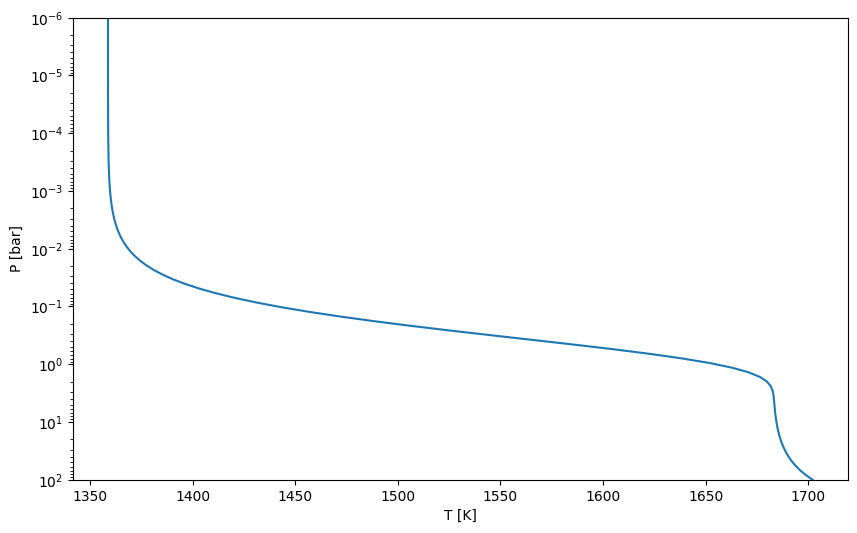

In [12]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(temperatures, pressures_bar)
ax.set_yscale('log')
ax.set_ylim([1e2, 1e-6])
ax.set_xlabel('T [K]')
ax.set_ylabel('P [bar]')

And recalculate the spectrum:

Text(0, 0.5, 'Planet flux, $F_{\\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

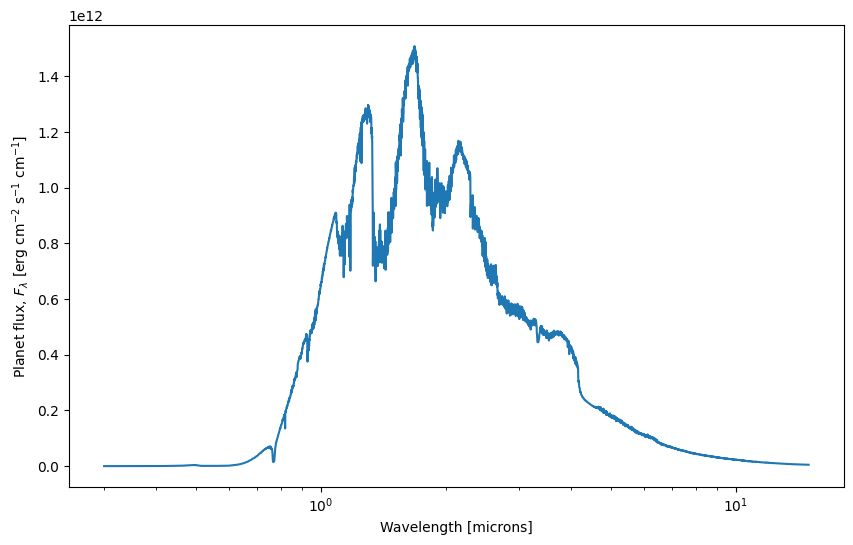

In [13]:
wavelengths, flux, _ = radtrans.calculate_flux(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses,
    reference_gravity=reference_gravity
)
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths*1e4, flux)

ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

Often when comparing models to data, we want to know what the spectrum would be as observed from earth. 
If we know the distance to the planet and the planet radius, we can calculate this using the function `petitRADTRANS.physics.flux2irradiance()`.

## An alternative: the `SpectralModel` object

The `Radtrans` object is pRT's foundation. It gives a lot of control on the spectral parameterisation, as shown in this notebook.

An alternative to `Radtrans` is the `SpectralModel` object, which uses `Radtrans` as a parent object, and automatise most of the steps required to obtain a spectrum. The `SpectralModel` object comes with default functions to automatically calculate the temperature, mass fractions, etc, and these functions can easily be customised. More information can be found in ["SpectralModel"](spectral_model.html).